In [32]:
from smt.utils.sm_test_case import SMTestCase
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG

from smt.applications.explainability_tools import PDFeatureInteractionDisplay

from smt.problems import MixedCantileverBeam
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
import numpy as np
import itertools
import random

In [2]:
nsamples = 300
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
x = sampling(nsamples)
y = fun(x)

feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$',
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$',
    r'$W_{dg}$', r'$W_{p}$',
]

sm = KRG(
    theta0=[1e-2] * x.shape[1],
    print_prediction=False
)
sm.set_training_values(x, y)
sm.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 300
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.1846051


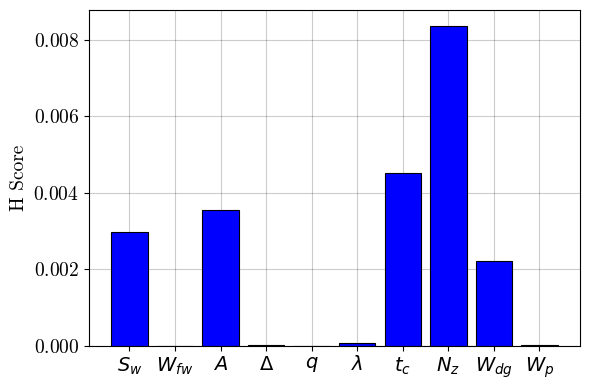

In [13]:
overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    sm,
    x,
    feature_names=feature_names, 
    ratio_samples=0.2,
)
fig = overall_pd_interaction.plot()
fig

In [14]:
assert len(overall_pd_interaction.h_scores) == x.shape[1]

CPU times: user 2.67 s, sys: 5.29 s, total: 7.95 s
Wall time: 1.12 s


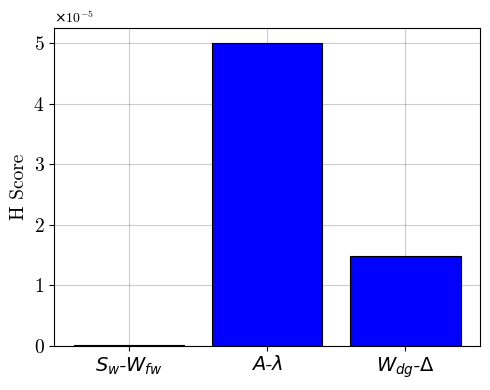

In [19]:
%%time
feature_pairs = [(0, 1), (2, 5), (8, 3)]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    sm,
    x,
    feature_pairs,
    feature_names=feature_names,
    ratio_samples=0.2,
)
fig = pairwise_pd_interaction.plot()
fig

In [36]:
feature_pairs = list(itertools.combinations(np.arange(3), 2))
random.shuffle(feature_pairs)
feature_pairs

[(0, 1), (1, 2), (0, 2)]

In [21]:
assert len(pairwise_pd_interaction.h_scores) == len(feature_pairs)

In [22]:
ndoe = 100
fun = MixedCantileverBeam()
# Design space
ds = DesignSpace([
    CategoricalVariable(values=[str(i + 1) for i in range(12)]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
x = fun.sample(ndoe)
y = fun(x)

# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
# Index for categorical features
categorical_feature_indices = [0]
# create mapping for the categories
categories_map = dict()
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }

sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )
sm.set_training_values(x, np.array(y))
sm.train()

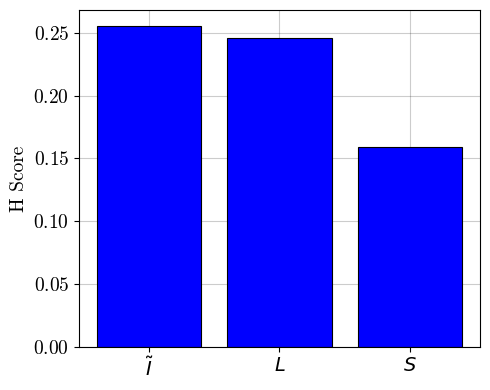

In [23]:
overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    sm,
    x,
    feature_names=feature_names, 
    ratio_samples=0.2,
    categorical_feature_indices=categorical_feature_indices,
)
fig = overall_pd_interaction.plot()
fig

In [24]:
assert len(overall_pd_interaction.h_scores) == x.shape[1]

CPU times: user 15.4 s, sys: 16.1 s, total: 31.5 s
Wall time: 4.24 s


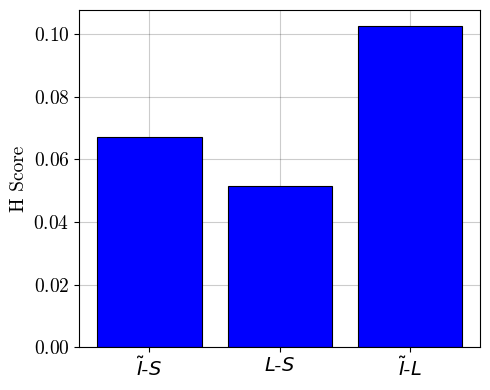

In [90]:
%%time
# feature_pairs = [(0, 1), (1, 2), (0, 2)]
num_feature_pairs = 3

# feature_pairs = list(itertools.combinations(np.arange(x.shape[1]).astype(int), 2))
feature_pairs = list(itertools.combinations([i for i in range(x.shape[1])], 2))
random.shuffle(feature_pairs)
feature_pairs = feature_pairs[:num_feature_pairs]
# feature_pairs = [(0, 1), (1, 2), (0, 2)]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    sm,
    x,
    feature_pairs,
    feature_names=feature_names,
    ratio_samples=0.2,
    categorical_feature_indices=categorical_feature_indices,
)
fig = pairwise_pd_interaction.plot()
fig

In [86]:
list(np.arange(x.shape[1]).astype(int))

[0, 1, 2]

In [74]:
list(list(feature_pairs))

[(0, 2), (1, 2), (0, 1)]

In [76]:
type(feature_pairs[0])

tuple

In [72]:
list(feature_pairs)

[(0, 2), (1, 2), (0, 1)]

In [57]:
feature_pairs == [(1, 2), (0, 2), (0, 1)]

True

array([0, 1, 2])

In [45]:
feature_pairs

[(0, 1), (1, 2), (0, 2)]

In [27]:
assert len(pairwise_pd_interaction.h_scores) == len(feature_pairs)

In [37]:
num_feature_pairs = 3

feature_pairs = list(itertools.combinations(np.arange(x.shape[1]), 2))
random.shuffle(feature_pairs)
feature_pairs = feature_pairs[:num_feature_pairs]

In [39]:
feature_pairs[0]

(0, 2)